In [47]:
using Distributed
cpuNum = length(Sys.cpu_info()) 
# number of cpu cores

addprocs(cpuNum - 1);
# using all cpu cores

@everywhere include("main.jl");

In [66]:
@everywhere pta = PTA(c=365.25/14, σ=1e2, nPTA=36, TObs=5.);

In [80]:
include("main.jl");
pta = PTA(c=365.25/14, σRMS=1e2, NP=36, TObs=5.);

1.0e-9

In [10]:
A0(α) = (6912*π^4*(5-4α)*ΔT^2*(4*snr)^2*σ^4/
    (M*(M-1)*T*((f0*T)^(-4α) * T^5 - (f0*ΔT)^(-4α) * ΔT^5)))^(1/4)

A0 (generic function with 1 method)

In [11]:
hc(α) = f -> A0(α)*(f/f0)^α

hc (generic function with 1 method)

In [12]:
function hcPI(det::Detector; fRange=nothing, nPoints=10^3, 
        ρth=nothing, αs=-20:0.5:20)
    
    if fRange != nothing
        fMin = fRange[1]
        fMax = fRange[2]
    else
        fMin, fMax = 1e-9, 1e-5
    end
    
    logfMin = log10(fMin)
    logfMax = log10(fMax)
    
    fs = 10 .^ range(logfMin, logfMax, length=nPoints)
    
    if ρth==nothing
        ρth = det.ρThSGWB
    end      
    
    Lines = map(α -> hc(α).(fs), αs)
    
    hcPIs = [maximum(hcat(Lines...)'[:,i]) for i in 1:nPoints]
    
    fs, hcPIs, Lines
end

hcPI (generic function with 1 method)

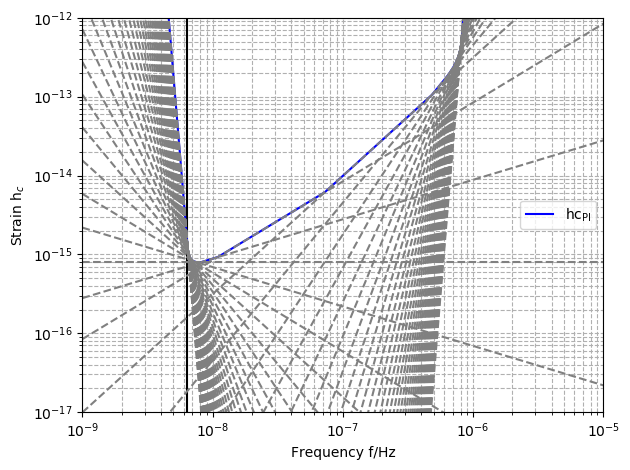

  0.827662 seconds (2.26 M allocations: 665.946 MiB, 4.48% gc time)


In [17]:
import PyPlot; const plt = PyPlot
function plotΩPI(det::Detector; figure_file=nothing, 
        plotΩPI=true, plotΩeff=false, plotΩPILines=false)
    
    fs, ΩPIResult, ΩPILines  = hcPI(det)
    Ωeffs = 5*det.Ωeff.(fs)
    
    fPlotRange = 1e-9, 1e-5
    hcPlotRange = 1e-17, 1e-12

    
    xlim(fPlotRange)
    ylim(hcPlotRange)  
    xlabel("Frequency f/Hz")
    ylabel(L"Strain h$_c$")
    grid("on", which="both", linestyle="--")
    
    if plotΩPI != false
        loglog(fs, ΩPIResult, "b", label=L"hc$_{\mathrm{PI}}$")        
    end
    
    if plotΩeff==true
        loglog(fs, Ωeffs, "b", label=L"Ω$_{\mathrm{eff}}$")
        if typeof(det)==PTA 
            vlines(det.fMin, 5*det.Ωeff(det.fMin), det.ΩPlotRange[2], "b")
        end
    end
    
    if plotΩPILines==true 
        [loglog(fs, ΩPILines[i], "--", color="gray") for i in 1:length(ΩPILines)]
    end
    vlines(det.fMin, 1e-17, 1e-12)
    legend()
    tight_layout()
    show()
end

@time plotΩPI(pta, plotΩPILines=true)